In [62]:

# Generate graphs for demonstration purposes
import utils.graph_generators as gen
import torch
import dgl
from rdkit.Chem import Draw
from rdkit import Chem
a=gen.load_zinc(n_samples=10)

from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as Morgan
from rdkit.Chem.QED import qed
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
from evaluation.moses_metrics  import metrics
from rdkit.Chem import Descriptors

In [105]:
import numpy as np
from collections import Counter
from functools import partial
import pandas as pd
import scipy
import os
import random
from multiprocessing import Pool
from collections import UserList, defaultdict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from rdkit import rdBase
from rdkit import Chem

In [17]:

lobsters_nx = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids_nx = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

In [18]:


#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device=torch.device('cpu')

grids = [ dgl.from_networkx(g,node_attrs=[], edge_attrs=[]).to(device) for g in grids_nx] # Convert graphs to DGL from NetworkX
lobsters = [ dgl.from_networkx(g,node_attrs=[], edge_attrs=[]).to(device) for g in lobsters_nx] # Convert graphs to DGL from NetworkX

In [19]:
print(grids[0],"\n", lobsters[0])

Graph(num_nodes=29, num_edges=64,
      ndata_schemes={}
      edata_schemes={}) 
 Graph(num_nodes=29, num_edges=64,
      ndata_schemes={}
      edata_schemes={})


In [266]:
# Compute all GNN-based metrics at once
from evaluation.evaluator import Evaluator
evaluator = Evaluator(device=device)
evaluator.evaluate_all(generated_dataset=grids, reference_dataset=lobsters)

orthogonal


{'activations_time': 0.028913021087646484,
 'fid': -7.175364174827337e-06,
 'fid_time': 0.05085492134094238,
 'kid': -0.7352618,
 'kid_time': 0.14959073066711426,
 'precision': 1.0,
 'recall': 1.0,
 'f1_pr': 1.00001,
 'precision_time': 0.0870969295501709,
 'recall_time': 0.0870969295501709,
 'f1_pr_time': 0.0870969295501709,
 'density': 1.2000000000000002,
 'coverage': 1.0,
 'f1_dc': 1.090919173552968,
 'density_time': 0.05186581611633301,
 'coverage_time': 0.05186581611633301,
 'f1_dc_time': 0.05186581611633301,
 'mmd_rbf': 0,
 'mmd_rbf_time': 0.06380510330200195,
 'mmd_linear': 0.0,
 'mmd_linear_time': 0.028913021087646484}

In [267]:
 #Alternatively, compute a single GNN-based metric. See evaluation/gin_evaluation.py for other metrics.
from evaluation.gin_evaluation import load_feature_extractor, MMDEvaluation

# Can tweak GIN hyperparameters, however defaults are set to our recommendations
gin = load_feature_extractor(device=device)
# Can tweak hyperparameters of MMD RBF, however defaults are set to our recommendations
mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=lobsters)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0}, time to compute: 0.069s


In [268]:
# Evaluation incorporating custom node/edge features.
# If no node features are provided, the default is degree features
# expressed as an integer.

node_feat_loc = 'feat'
edge_feat_loc = 'feat'
node_feat_dim = 10
edge_feat_dim = 5

# Create random node/edge features
for g in grids:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)
    
for g in lobsters:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)

# Load GIN
gin = load_feature_extractor(
    device=device, input_dim=node_feat_dim, edge_feat_dim=edge_feat_dim,
    node_feat_loc=node_feat_loc, edge_feat_loc=edge_feat_loc)

mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=lobsters, reference_dataset=grids)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0.20000000298023224}, time to compute: 0.047s


In [269]:
# To quickly demonstrate sensitivity to node/edge features, let's create
# a copy of the grid graphs and slightly alter the node/edge feat distributions
import copy

result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=grids)
print('MMD RBF for grids with itself: {}'.format(result['mmd_rbf']))

grids_copy = [copy.deepcopy(g) for g in grids]
for g in grids_copy:
    g.ndata[node_feat_loc] *= 1.15
    g.edata[edge_feat_loc] *= 1.15
    
result, time = mmd_eval.evaluate(reference_dataset=grids, generated_dataset=grids_copy)
print('MMD RBF after altering node/edge feat. distributions: {}'.format(result['mmd_rbf']))

MMD RBF for grids with itself: 0
MMD RBF after altering node/edge feat. distributions: 0.20000000298023224


In [276]:
a=gen.load_zinc(n_samples=10)
grids=a
lobsters=a
print(len(grids[0].ndata['attr']))
print(grids[0].ndata['attr']  , grids[0].ndata['feat'])

29
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [58]:

lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device=torch.device('cpu')

grids = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in grids] # Convert graphs to DGL from NetworkX
lobsters = [ dgl.from_networkx(g,node_attrs=['feat'], edge_attrs=['feat']).to(device) for g in lobsters] # Convert graphs to DGL from NetworkX

In [271]:
# Compute all GNN-based metrics at once
from evaluation.evaluator import Evaluator
evaluator = Evaluator(device=device)
evaluator.evaluate_all(generated_dataset=grids, reference_dataset=lobsters)

orthogonal


{'activations_time': 0.02293705940246582,
 'fid': -5.0272063134571e-06,
 'fid_time': 0.026926279067993164,
 'kid': -0.6205814,
 'kid_time': 0.03989148139953613,
 'precision': 1.0,
 'recall': 1.0,
 'f1_pr': 1.00001,
 'precision_time': 0.05186009407043457,
 'recall_time': 0.05186009407043457,
 'f1_pr_time': 0.05186009407043457,
 'density': 1.2000000000000002,
 'coverage': 1.0,
 'f1_dc': 1.090919173552968,
 'density_time': 0.038893699645996094,
 'coverage_time': 0.038893699645996094,
 'f1_dc_time': 0.038893699645996094,
 'mmd_rbf': 0,
 'mmd_rbf_time': 0.06283307075500488,
 'mmd_linear': 0.0,
 'mmd_linear_time': 0.02393341064453125}

In [273]:
 #Alternatively, compute a single GNN-based metric. See evaluation/gin_evaluation.py for other metrics.
from evaluation.gin_evaluation import load_feature_extractor, MMDEvaluation

# Can tweak GIN hyperparameters, however defaults are set to our recommendations
gin = load_feature_extractor(device=device)
# Can tweak hyperparameters of MMD RBF, however defaults are set to our recommendations
mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=lobsters)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0}, time to compute: 0.046s


In [274]:
# Evaluation incorporating custom node/edge features.
# If no node features are provided, the default is degree features
# expressed as an integer.

node_feat_loc = 'feat'
edge_feat_loc = 'feat'
node_feat_dim = 10
edge_feat_dim = 5

# Create random node/edge features
for g in grids:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)
    
for g in lobsters:
    num_nodes = g.number_of_nodes()
    g.ndata[node_feat_loc] = torch.randn(num_nodes, node_feat_dim).to(g.device)
    num_edges = g.number_of_edges()
    g.edata[edge_feat_loc] = torch.randn(num_edges, edge_feat_dim).to(g.device)

# Load GIN
gin = load_feature_extractor(
    device=device, input_dim=node_feat_dim, edge_feat_dim=edge_feat_dim,
    node_feat_loc=node_feat_loc, edge_feat_loc=edge_feat_loc)

mmd_eval = MMDEvaluation(gin)
result, time = mmd_eval.evaluate(generated_dataset=lobsters, reference_dataset=grids)
print('result: {}, time to compute: {:.3f}s'.format(result, time))

orthogonal
result: {'mmd_rbf': 0.20000000298023224}, time to compute: 0.130s


In [275]:
# To quickly demonstrate sensitivity to node/edge features, let's create
# a copy of the grid graphs and slightly alter the node/edge feat distributions
import copy

result, time = mmd_eval.evaluate(generated_dataset=grids, reference_dataset=grids)
print('MMD RBF for grids with itself: {}'.format(result['mmd_rbf']))

grids_copy = [copy.deepcopy(g) for g in grids]
for g in grids_copy:
    g.ndata[node_feat_loc] *= 5
    g.edata[edge_feat_loc] *= 5
    
result, time = mmd_eval.evaluate(reference_dataset=grids, generated_dataset=grids_copy)
print('MMD RBF after altering node/edge feat. distributions: {}'.format(result['mmd_rbf']))

MMD RBF for grids with itself: 0
MMD RBF after altering node/edge feat. distributions: 0.7479543089866638


In [91]:
a=gen.load_zinc(n_samples=10)


In [92]:
grids=a
lobsters=a

In [174]:
test=grids[0]
test_nx=dgl.to_networkx(test, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])

In [94]:
test_nx.edges(data=True)

OutMultiEdgeDataView([(0, 1, {'id': 0, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (1, 0, {'id': 1, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (1, 2, {'id': 2, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (2, 1, {'id': 3, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (2, 3, {'id': 4, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (2, 28, {'id': 5, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (3, 2, {'id': 6, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (3, 4, {'id': 7, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (4, 3, {'id': 8, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (4, 5, {'id': 9, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (5, 4, {'id': 10, 'attr': tensor([0., 0., 1., 0.]), 'feat': tensor(2)}), (5, 6, {'id': 11, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (5, 27, {'id': 12, 'attr': tensor([0., 1., 0., 0.]), 'feat': tensor(1)}), (6, 5, {'id': 13, 'attr': tensor([0.,

In [101]:
(test.ndata["feat"])

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 5, 1, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0])

In [165]:
(test.edata["feat"])

tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2])

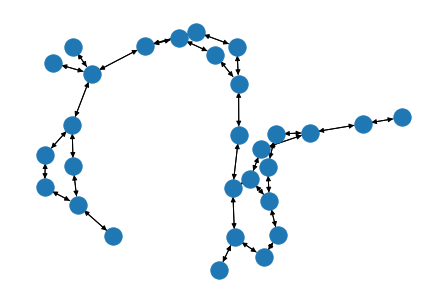

In [132]:
 import networkx as nx
 nx.draw(test_nx)

In [5]:

#https://github.com/graphdeeplearning/benchmarking-gnns/issues/42
https://stackoverflow.com/questions/51195392/smiles-from-graph


In [46]:

def get_atomic_number():
    dict_of_atomic_no ={ 'C':6, 'O':8, 'N':7, 'F':9, 'S':16, 'Cl':17,  'Br':35, 'I':53, 'P':15}
    return dict_of_atomic_no

def get_dict_of_nodes():
    dict_of_nodes={0: 'C', 1: 'O',2: 'N',3: 'F',4: 'C',5: 'S', 6: 'Cl', 7: 'O', 8: 'N',9: 'Br', 10: 'N', 11: 'N', 12: 'N', 13: 'N', 14: 'S ', 15: 'I', 16: 'P', 17: 'O', 18: 'N', 19: 'O',20: 'S', 21: 'P' ,22: 'P',23: 'C', 24: 'P',25: 'S',26: 'C',27: 'P'}
    return dict_of_nodes

def nx_to_mol(nx_graph , edge_label='feat', node_label='feat'):
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    
    #dictionary of atomic numbers
    dict_of_atomic_no=get_atomic_number()
    
    #dictionary of nodes
    node_atom_values=get_dict_of_nodes()
    
    
    for i,n in enumerate(nx_graph.nodes(data=True)):
        a = Chem.Atom( dict_of_atomic_no[node_atom_values[int(n[1][node_label].numpy())]])
        molIdx = mol.AddAtom(a)
        #print(molIdx)
        node_to_idx[i] = molIdx
        
    for edge in nx_graph.edges(data=True):
            bond=int(edge[2][edge_label])
            ix=edge[0]
            iy=edge[1]
            
            # only traverse half the matrix
            if iy <= ix:
                continue
            if bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
                
            elif bond == 3:
                    bond_type=Chem.rdchem.BondType.TRIPLE
                    mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)
            elif bond == 4:
                bond_type = Chem.rdchem.BondType.AROMATIC
                mol.AddBond(node_to_idx[ix], node_to_idx[iy] ,bond_type)

        # Convert RWMol to Mol object
    mol = mol.GetMol()  
    try:
        Chem.SanitizeMol(mol)
    except:
        # print(node_list)
        # print(Chem.MolToSmiles(mol))
        return None
    return mol       



In [49]:
lobsters = [ dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat'])  for g in a]
grids = [dgl.to_networkx(g, node_attrs=['attr','feat'], edge_attrs=['attr','feat']) for g in a]

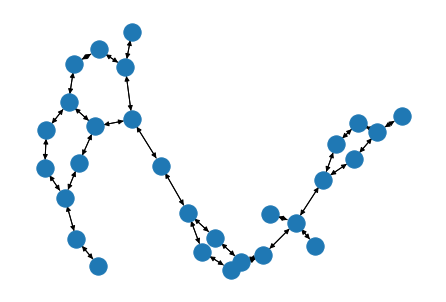

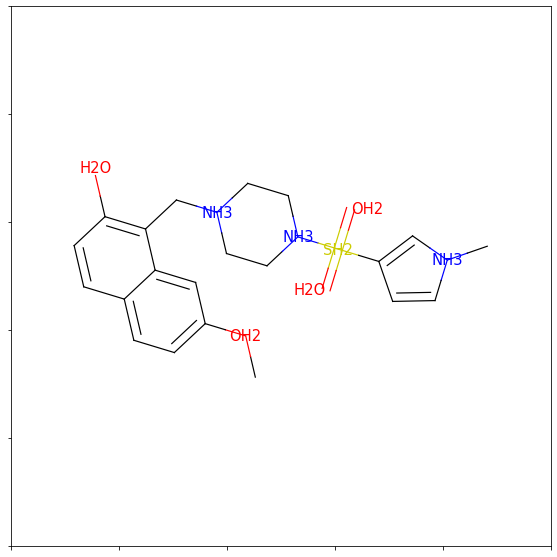

In [309]:
for g in lobsters:
   nx.draw(g)
   Draw.MolToMPL(nx_to_mol(g))
   break
   

In [58]:
losters_mol= [nx_to_mol(g) for g in lobsters]
grids_mol=[nx_to_mol(g) for g in grids]

In [59]:
lobsters_smiles=[Chem.MolToSmiles(g) for g in losters_mol]
grids_smiles=[Chem.MolToSmiles(g) for g in grids_mol]


In [61]:
t=losters_mol[2]

In [54]:
def QED(mol):
    """
    Computes RDKit's QED score
    """
    return qed(mol)
qed(t)

In [57]:
def logP(mol):
    """
    Computes RDKit's logP
    """
    return Chem.Crippen.MolLogP(mol)
logP(t)

2.6438000000000006

In [64]:
def get_n_rings(mol):
    """
    Computes the number of rings in a molecule
    """
    return mol.GetRingInfo().NumRings()
get_n_rings(t)

2

In [75]:
def compute_fragments(mol_list, n_jobs=1):
    """
    fragment list of mols using BRICS and return smiles list
    """
    fragments = Counter()
    for mol_frag in mapper(n_jobs)(fragmenter, mol_list):
        fragments.update(mol_frag)
    return fragments

compute_fragments(losters_mol)

Counter({'[12*]S(=O)(=O)c1ccn(C)c1': 1,
         '[16*]c1ccc2ccc(O)c([16*])c2c1': 1,
         '[3*]OC': 1,
         '[4*]C[8*]': 4,
         '[5*]N1CCN([5*])CC1': 2,
         '[1*]C([1*])=O': 3,
         '[1*]C([6*])=O': 1,
         '[15*]C1CC1': 2,
         '[16*]c1ccncc1': 1,
         '[4*]C(C)C': 1,
         '[4*]CC[4*]': 1,
         '[5*]N([5*])[5*]': 1,
         '[5*]N[5*]': 7,
         '[16*]c1ccc(Cl)cc1': 1,
         '[5*]N([5*])C': 1,
         '[11*]S[11*]': 1,
         '[14*]c1cc(O)n2ncc(C#N)c2n1': 1,
         '[15*]C1CCCCC1': 2,
         '[9*]n1c([14*])nc(C)c1C': 1,
         '[16*]c1cccc2ccccc12': 1,
         '[4*]C(CC)(CC)C(=O)C[8*]': 1,
         '[5*]N(C)C': 1,
         '[1*]C(=O)NNc1ccc([14*])nn1': 1,
         '[16*]c1ccccc1[16*]': 1,
         '[4*]C([8*])C': 2,
         '[8*]C(F)(F)F': 1,
         '[9*]n1cccn1': 1,
         '[16*]c1c(C)nn(C)c1Cl': 1,
         '[4*]CC(C)(O)CCC(C)C': 1,
         '[16*]c1ccccc1': 2,
         '[3*]OC(O)=C(C#N)C([6*])=O': 1,
         '[4*]CC':

In [82]:
def NP(mol):
    """
    Computes RDKit's Natural Product-likeness score
    """
    return npscorer.scoreMol(mol)

NP(t)

-1.9761440353718627

In [79]:
def SA(mol):
    """
    Computes RDKit's Synthetic Accessibility score
    """
    return sascorer.calculateScore(mol)
SA(t)

1.7643596641595192

In [84]:
def fragmenter(mol):
    """
    fragment mol using BRICS and return smiles list
    """
    fgs = AllChem.FragmentOnBRICSBonds(get_mol(mol))
    fgs_smi = Chem.MolToSmiles(fgs).split(".")
    return fgs_smi
fragmenter(t)

['[1*]C([1*])=O',
 '[15*]C1CC1',
 '[16*]c1ccc(Cl)cc1',
 '[4*]C[8*]',
 '[5*]N([5*])C',
 '[5*]N[5*]']

In [87]:
def compute_scaffolds(mol_list, n_jobs=1, min_rings=2):
    """
    Extracts a scafold from a molecule in a form of a canonic SMILES
    """
    scaffolds = Counter()
    map_ = mapper(n_jobs)
    scaffolds = Counter(
        map_(partial(compute_scaffold, min_rings=min_rings), mol_list))
    if None in scaffolds:
        scaffolds.pop(None)
    return scaffolds
compute_scaffolds(losters_mol)

Counter({'O=S(=O)(c1cc[nH]c1)N1CCN(Cc2cccc3ccccc23)CC1': 1,
         'O=C(NCCNC1CC1)N1CCN(C(=O)c2ccncc2)CC1': 1,
         'O=C(NCc1ccccc1)NC1CC1': 1,
         'c1cn(C2CCCCC2)c(SCc2ccn3nccc3n2)n1': 1,
         'c1ccc2ccccc2c1': 1,
         'O=C(NCc1ccccc1)NNc1ccc(-n2cccn2)nn1': 1,
         'c1ccc(-c2ccno2)cc1': 1,
         'O=C(Cc1ccsc1)NCC1CCCCC1': 1})

In [90]:
def fingerprint(smiles_or_mol, fp_type='maccs', dtype=None, morgan__r=2,
                morgan__n=1024, *args, **kwargs):
    """
    Generates fingerprint for SMILES
    If smiles is invalid, returns None
    Returns numpy array of fingerprint bits

    Parameters:
        smiles: SMILES string
        type: type of fingerprint: [MACCS|morgan]
        dtype: if not None, specifies the dtype of returned array
    """
    fp_type = fp_type.lower()
    molecule = get_mol(smiles_or_mol, *args, **kwargs)
    if molecule is None:
        return None
    if fp_type == 'maccs':
        keys = MACCSkeys.GenMACCSKeys(molecule)
        keys = np.array(keys.GetOnBits())
        fingerprint = np.zeros(166, dtype='uint8')
        if len(keys) != 0:
            fingerprint[keys - 1] = 1  # We drop 0-th key that is always zero
    elif fp_type == 'morgan':
        fingerprint = np.asarray(Morgan(molecule, morgan__r, nBits=morgan__n),
                                 dtype='uint8')
    else:
        raise ValueError("Unknown fingerprint type {}".format(fp_type))
    if dtype is not None:
        fingerprint = fingerprint.astype(dtype)
    return fingerprint

fingerprint(lobsters_smiles[0])

In [101]:
def fingerprints(smiles_mols_array, n_jobs=1, already_unique=False, *args,
                 **kwargs):
    '''
    Computes fingerprints of smiles np.array/list/pd.Series with n_jobs workers
    e.g.fingerprints(smiles_mols_array, type='morgan', n_jobs=10)
    Inserts np.NaN to rows corresponding to incorrect smiles.
    IMPORTANT: if there is at least one np.NaN, the dtype would be float
    Parameters:
        smiles_mols_array: list/array/pd.Series of smiles or already computed
            RDKit molecules
        n_jobs: number of parralel workers to execute
        already_unique: flag for performance reasons, if smiles array is big
            and already unique. Its value is set to True if smiles_mols_array
            contain RDKit molecules already.
    '''
    if isinstance(smiles_mols_array, pd.Series):
        smiles_mols_array = smiles_mols_array.values
    else:
        smiles_mols_array = np.asarray(smiles_mols_array)
    if not isinstance(smiles_mols_array[0], str):
        already_unique = True

    if not already_unique:
        smiles_mols_array, inv_index = np.unique(smiles_mols_array,
                                                 return_inverse=True)

    fps = mapper(n_jobs)(
        partial(fingerprint, *args, **kwargs), smiles_mols_array
    )

    length = 1
    for fp in fps:
        if fp is not None:
            length = fp.shape[-1]
            first_fp = fp
            break
    fps = [fp if fp is not None else np.array([np.NaN]).repeat(length)[None, :]
           for fp in fps]
    if scipy.sparse.issparse(first_fp):
        fps = scipy.sparse.vstack(fps).tocsr()
    else:
        fps = np.vstack(fps)
    if not already_unique:
        return fps[inv_index]
    return fps


fingerprints(lobsters_smiles, n_jobs=1, already_unique=False)

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]], dtype=uint8)

In [108]:
_mcf = pd.read_csv( 'evaluation/moses_metrics/mcf.csv')
_pains = pd.read_csv(('evaluation/moses_metrics/wehi_pains.csv'),
                     names=['smarts', 'names'])
_filters = [Chem.MolFromSmarts(x) for x in
            _mcf.append(_pains, sort=True)['smarts'].values]

In [112]:

def mol_passes_filters(mol,
                       allowed=None,
                       isomericSmiles=False):
    """
    Checks if mol
    * passes MCF and PAINS filters,
    * has only allowed atoms
    * is not charged
    """
    allowed = allowed or {'C', 'N', 'S', 'O', 'F', 'Cl', 'Br', 'H'}
    mol = get_mol(mol)
    if mol is None:
        return False
    ring_info = mol.GetRingInfo()
    if ring_info.NumRings() != 0 and any(
            len(x) >= 8 for x in ring_info.AtomRings()
    ):
        return False
    h_mol = Chem.AddHs(mol)
    if any(atom.GetFormalCharge() != 0 for atom in mol.GetAtoms()):
        return False
    if any(atom.GetSymbol() not in allowed for atom in mol.GetAtoms()):
        return False
    if any(h_mol.HasSubstructMatch(smarts) for smarts in _filters):
        return False
    smiles = Chem.MolToSmiles(mol, isomericSmiles=isomericSmiles)
    if smiles is None or len(smiles) == 0:
        return False
    if Chem.MolFromSmiles(smiles) is None:
        return False
    return True
mol_passes_filters(t)

True

In [113]:
def set_torch_seed_to_all_gens(_):
    seed = torch.initial_seed() % (2**32 - 1)
    random.seed(seed)
    np.random.seed(seed)


class SpecialTokens:
    bos = '<bos>'
    eos = '<eos>'
    pad = '<pad>'
    unk = '<unk>'


class CharVocab:
    @classmethod
    def from_data(cls, data, *args, **kwargs):
        chars = set()
        for string in data:
            chars.update(string)

        return cls(chars, *args, **kwargs)

    def __init__(self, chars, ss=SpecialTokens):
        if (ss.bos in chars) or (ss.eos in chars) or \
                (ss.pad in chars) or (ss.unk in chars):
            raise ValueError('SpecialTokens in chars')

        all_syms = sorted(list(chars)) + [ss.bos, ss.eos, ss.pad, ss.unk]

        self.ss = ss
        self.c2i = {c: i for i, c in enumerate(all_syms)}
        self.i2c = {i: c for i, c in enumerate(all_syms)}

    def __len__(self):
        return len(self.c2i)

    @property
    def bos(self):
        return self.c2i[self.ss.bos]

    @property
    def eos(self):
        return self.c2i[self.ss.eos]

    @property
    def pad(self):
        return self.c2i[self.ss.pad]

    @property
    def unk(self):
        return self.c2i[self.ss.unk]

    def char2id(self, char):
        if char not in self.c2i:
            return self.unk

        return self.c2i[char]

    def id2char(self, id):
        if id not in self.i2c:
            return self.ss.unk

        return self.i2c[id]

    def string2ids(self, string, add_bos=False, add_eos=False):
        ids = [self.char2id(c) for c in string]

        if add_bos:
            ids = [self.bos] + ids
        if add_eos:
            ids = ids + [self.eos]

        return ids

    def ids2string(self, ids, rem_bos=True, rem_eos=True):
        if len(ids) == 0:
            return ''
        if rem_bos and ids[0] == self.bos:
            ids = ids[1:]
        if rem_eos and ids[-1] == self.eos:
            ids = ids[:-1]

        string = ''.join([self.id2char(id) for id in ids])

        return string


class OneHotVocab(CharVocab):
    def __init__(self, *args, **kwargs):
        super(OneHotVocab, self).__init__(*args, **kwargs)
        self.vectors = torch.eye(len(self.c2i))


def mapper(n_jobs):
    '''
    Returns function for map call.
    If n_jobs == 1, will use standard map
    If n_jobs > 1, will use multiprocessing pool
    If n_jobs is a pool object, will return its map function
    '''
    if n_jobs == 1:
        def _mapper(*args, **kwargs):
            return list(map(*args, **kwargs))

        return _mapper
    if isinstance(n_jobs, int):
        pool = Pool(n_jobs)

        def _mapper(*args, **kwargs):
            try:
                result = pool.map(*args, **kwargs)
            finally:
                pool.terminate()
            return result

        return _mapper
    return n_jobs.map


class Logger(UserList):
    def __init__(self, data=None):
        super().__init__()
        self.sdata = defaultdict(list)
        for step in (data or []):
            self.append(step)

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.data[key]
        if isinstance(key, slice):
            return Logger(self.data[key])
        ldata = self.sdata[key]
        if isinstance(ldata[0], dict):
            return Logger(ldata)
        return ldata

    def append(self, step_dict):
        super().append(step_dict)
        for k, v in step_dict.items():
            self.sdata[k].append(v)

    def save(self, path):
        df = pd.DataFrame(list(self))
        df.to_csv(path, index=None)


class LogPlotter:
    def __init__(self, log):
        self.log = log

    def line(self, ax, name):
        if isinstance(self.log[0][name], dict):
            for k in self.log[0][name]:
                ax.plot(self.log[name][k], label=k)
            ax.legend()
        else:
            ax.plot(self.log[name])

        ax.set_ylabel('value')
        ax.set_xlabel('epoch')
        ax.set_title(name)

    def grid(self, names, size=7):
        _, axs = plt.subplots(nrows=len(names) // 2, ncols=2,
                              figsize=(size * 2, size * (len(names) // 2)))

        for ax, name in zip(axs.flatten(), names):
            self.line(ax, name)


class CircularBuffer:
    def __init__(self, size):
        self.max_size = size
        self.data = np.zeros(self.max_size)
        self.size = 0
        self.pointer = -1

    def add(self, element):
        self.size = min(self.size + 1, self.max_size)
        self.pointer = (self.pointer + 1) % self.max_size
        self.data[self.pointer] = element
        return element

    def last(self):
        assert self.pointer != -1, "Can't get an element from an empty buffer!"
        return self.data[self.pointer]

    def mean(self):
        if self.size > 0:
            return self.data[:self.size].mean()
        return 0.0


def disable_rdkit_log():
    rdBase.DisableLog('rdApp.*')


def enable_rdkit_log():
    rdBase.EnableLog('rdApp.*')


def get_mol(smiles_or_mol):
    '''
    Loads SMILES/molecule into RDKit's object
    '''
    if isinstance(smiles_or_mol, str):
        if len(smiles_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smiles_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smiles_or_mol


class StringDataset:
    def __init__(self, vocab, data):
        """
        Creates a convenient Dataset with SMILES tokinization

        Arguments:
            vocab: CharVocab instance for tokenization
            data (list): SMILES strings for the dataset
        """
        self.vocab = vocab
        self.tokens = [vocab.string2ids(s) for s in data]
        self.data = data
        self.bos = vocab.bos
        self.eos = vocab.eos

    def __len__(self):
        """
        Computes a number of objects in the dataset
        """
        return len(self.tokens)

    def __getitem__(self, index):
        """
        Prepares torch tensors with a given SMILES.

        Arguments:
            index (int): index of SMILES in the original dataset

        Returns:
            A tuple (with_bos, with_eos, smiles), where
            * with_bos is a torch.long tensor of SMILES tokens with
                BOS (beginning of a sentence) token
            * with_eos is a torch.long tensor of SMILES tokens with
                EOS (end of a sentence) token
            * smiles is an original SMILES from the dataset
        """
        tokens = self.tokens[index]
        with_bos = torch.tensor([self.bos] + tokens, dtype=torch.long)
        with_eos = torch.tensor(tokens + [self.eos], dtype=torch.long)
        return with_bos, with_eos, self.data[index]

    def default_collate(self, batch, return_data=False):
        """
        Simple collate function for SMILES dataset. Joins a
        batch of objects from StringDataset into a batch

        Arguments:
            batch: list of objects from StringDataset
            pad: padding symbol, usually equals to vocab.pad
            return_data: if True, will return SMILES used in a batch

        Returns:
            with_bos, with_eos, lengths [, data] where
            * with_bos: padded sequence with BOS in the beginning
            * with_eos: padded sequence with EOS in the end
            * lengths: array with SMILES lengths in the batch
            * data: SMILES in the batch

        Note: output batch is sorted with respect to SMILES lengths in
            decreasing order, since this is a default format for torch
            RNN implementations
        """
        with_bos, with_eos, data = list(zip(*batch))
        lengths = [len(x) for x in with_bos]
        order = np.argsort(lengths)[::-1]
        with_bos = [with_bos[i] for i in order]
        with_eos = [with_eos[i] for i in order]
        lengths = [lengths[i] for i in order]
        with_bos = torch.nn.utils.rnn.pad_sequence(
            with_bos, padding_value=self.vocab.pad
        )
        with_eos = torch.nn.utils.rnn.pad_sequence(
            with_eos, padding_value=self.vocab.pad
        )
        if return_data:
            data = np.array(data)[order]
            return with_bos, with_eos, lengths, data
        return with_bos, with_eos, lengths


def batch_to_device(batch, device):
    return [
        x.to(device) if isinstance(x, torch.Tensor) else x
        for x in batch
    ]


In [55]:
qed(t)

0.8628610419282682

'C:\\Users\\cs843'